# Phishing Attack Detection

## 1. Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.linear_model import LogisticRegression

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 2. Loading Dataset and Exploratory Data Analysis

In [4]:
data = pd.read_csv('datasets/phishing-website-detector/phishing.csv')
data.head()

,Index,UsingIP,LongURL,ShortURL,Symbol@,Redirecting//,PrefixSuffix-,SubDomains,HTTPS,DomainRegLen,...,UsingPopupWindow,IframeRedirection,AgeofDomain,DNSRecording,WebsiteTraffic,PageRank,GoogleIndex,LinksPointingToPage,StatsReport,class
0,0,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
1,1,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
2,2,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
3,3,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1
4,4,-1,0,-1,1,-1,-1,1,1,-1,...,1,1,1,1,1,-1,1,-1,-1,1


In [5]:
data.shape

(11054, 32)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11054 entries, 0 to 11053
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Index                11054 non-null  int64
 1   UsingIP              11054 non-null  int64
 2   LongURL              11054 non-null  int64
 3   ShortURL             11054 non-null  int64
 4   Symbol@              11054 non-null  int64
 5   Redirecting//        11054 non-null  int64
 6   PrefixSuffix-        11054 non-null  int64
 7   SubDomains           11054 non-null  int64
 8   HTTPS                11054 non-null  int64
 9   DomainRegLen         11054 non-null  int64
 10  Favicon              11054 non-null  int64
 11  NonStdPort           11054 non-null  int64
 12  HTTPSDomainURL       11054 non-null  int64
 13  RequestURL           11054 non-null  int64
 14  AnchorURL            11054 non-null  int64
 15  LinksInScriptTags    11054 non-null  int64
 16  ServerFormHandler    1

In [7]:
data.nunique()

Index                  11054
UsingIP                    2
LongURL                    3
ShortURL                   2
Symbol@                    2
Redirecting//              2
PrefixSuffix-              2
SubDomains                 3
HTTPS                      3
DomainRegLen               2
Favicon                    2
NonStdPort                 2
HTTPSDomainURL             2
RequestURL                 2
AnchorURL                  3
LinksInScriptTags          3
ServerFormHandler          3
InfoEmail                  2
AbnormalURL                2
WebsiteForwarding          2
StatusBarCust              2
DisableRightClick          2
UsingPopupWindow           2
IframeRedirection          2
AgeofDomain                2
DNSRecording               2
WebsiteTraffic             3
PageRank                   2
GoogleIndex                2
LinksPointingToPage        3
StatsReport                2
class                      2
dtype: int64

In [8]:
data = data.drop(['Index'],axis=1) # drop index column

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
UsingIP,11054.0,0.313914,0.949495,-1.0,-1.0,1.0,1.0,1.0
LongURL,11054.0,-0.633345,0.765973,-1.0,-1.0,-1.0,-1.0,1.0
ShortURL,11054.0,0.738737,0.674024,-1.0,1.0,1.0,1.0,1.0
Symbol@,11054.0,0.700561,0.713625,-1.0,1.0,1.0,1.0,1.0
Redirecting//,11054.0,0.741632,0.670837,-1.0,1.0,1.0,1.0,1.0
PrefixSuffix-,11054.0,-0.734938,0.678165,-1.0,-1.0,-1.0,-1.0,1.0
SubDomains,11054.0,0.064049,0.817492,-1.0,-1.0,0.0,1.0,1.0
HTTPS,11054.0,0.251040,0.911856,-1.0,-1.0,1.0,1.0,1.0
DomainRegLen,11054.0,-0.336711,0.941651,-1.0,-1.0,-1.0,1.0,1.0
Favicon,11054.0,0.628551,0.777804,-1.0,1.0,1.0,1.0,1.0


<Axes: >

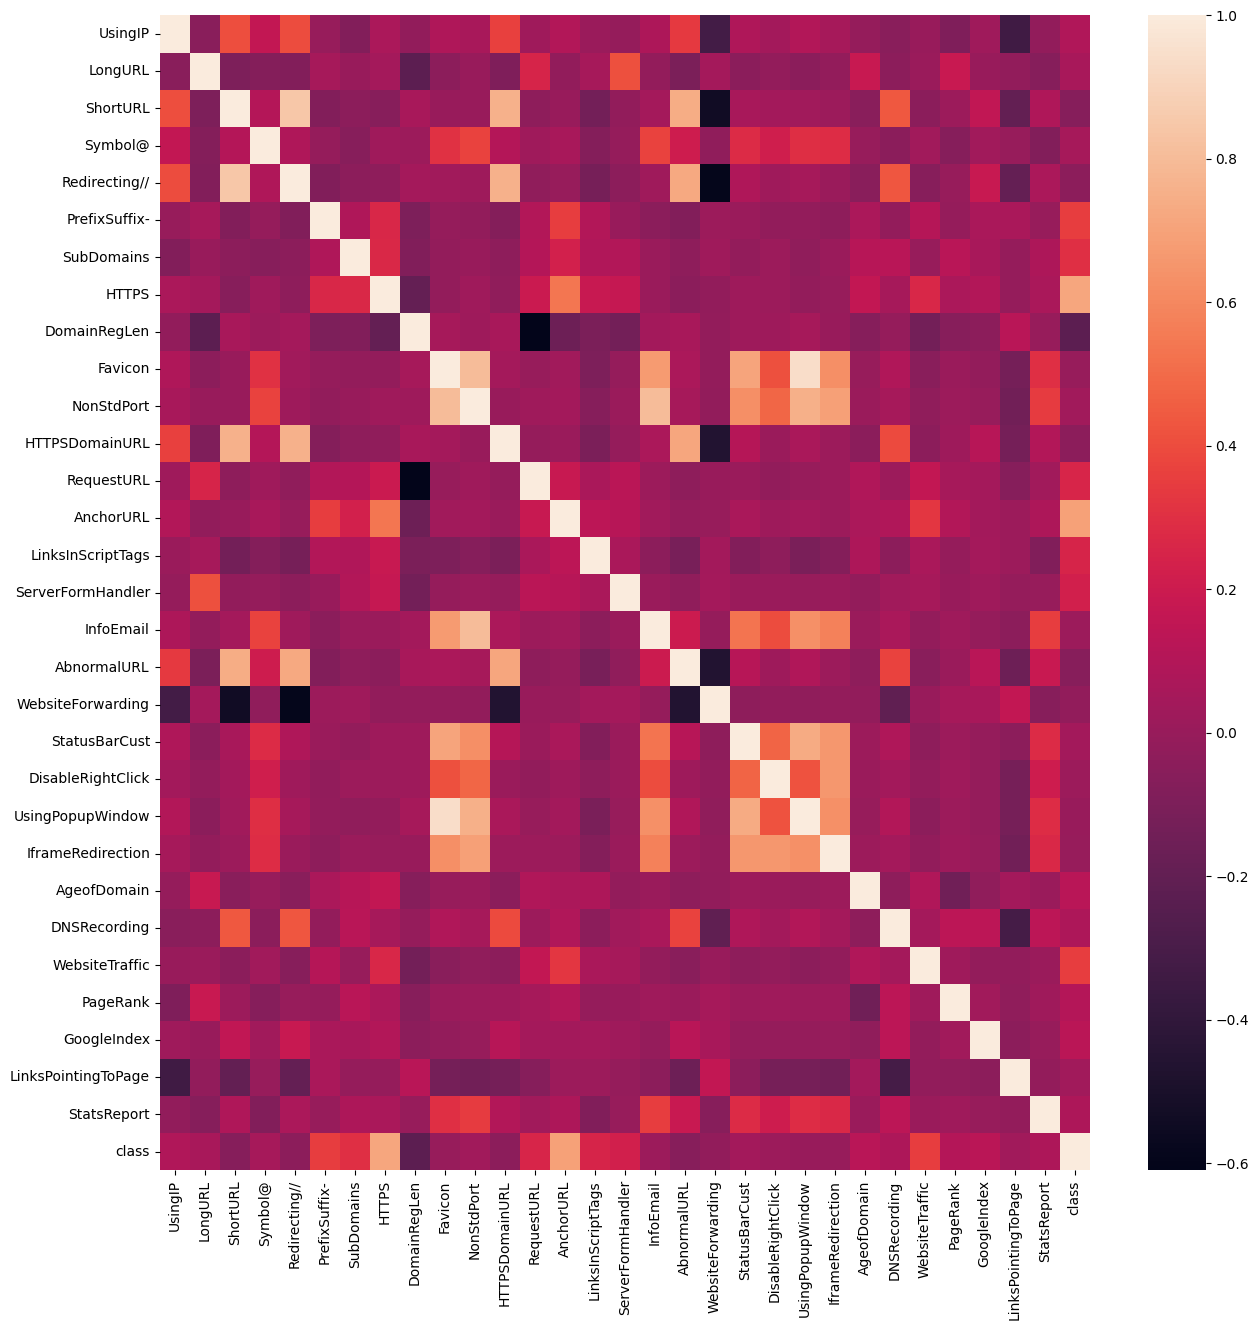

In [10]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr())

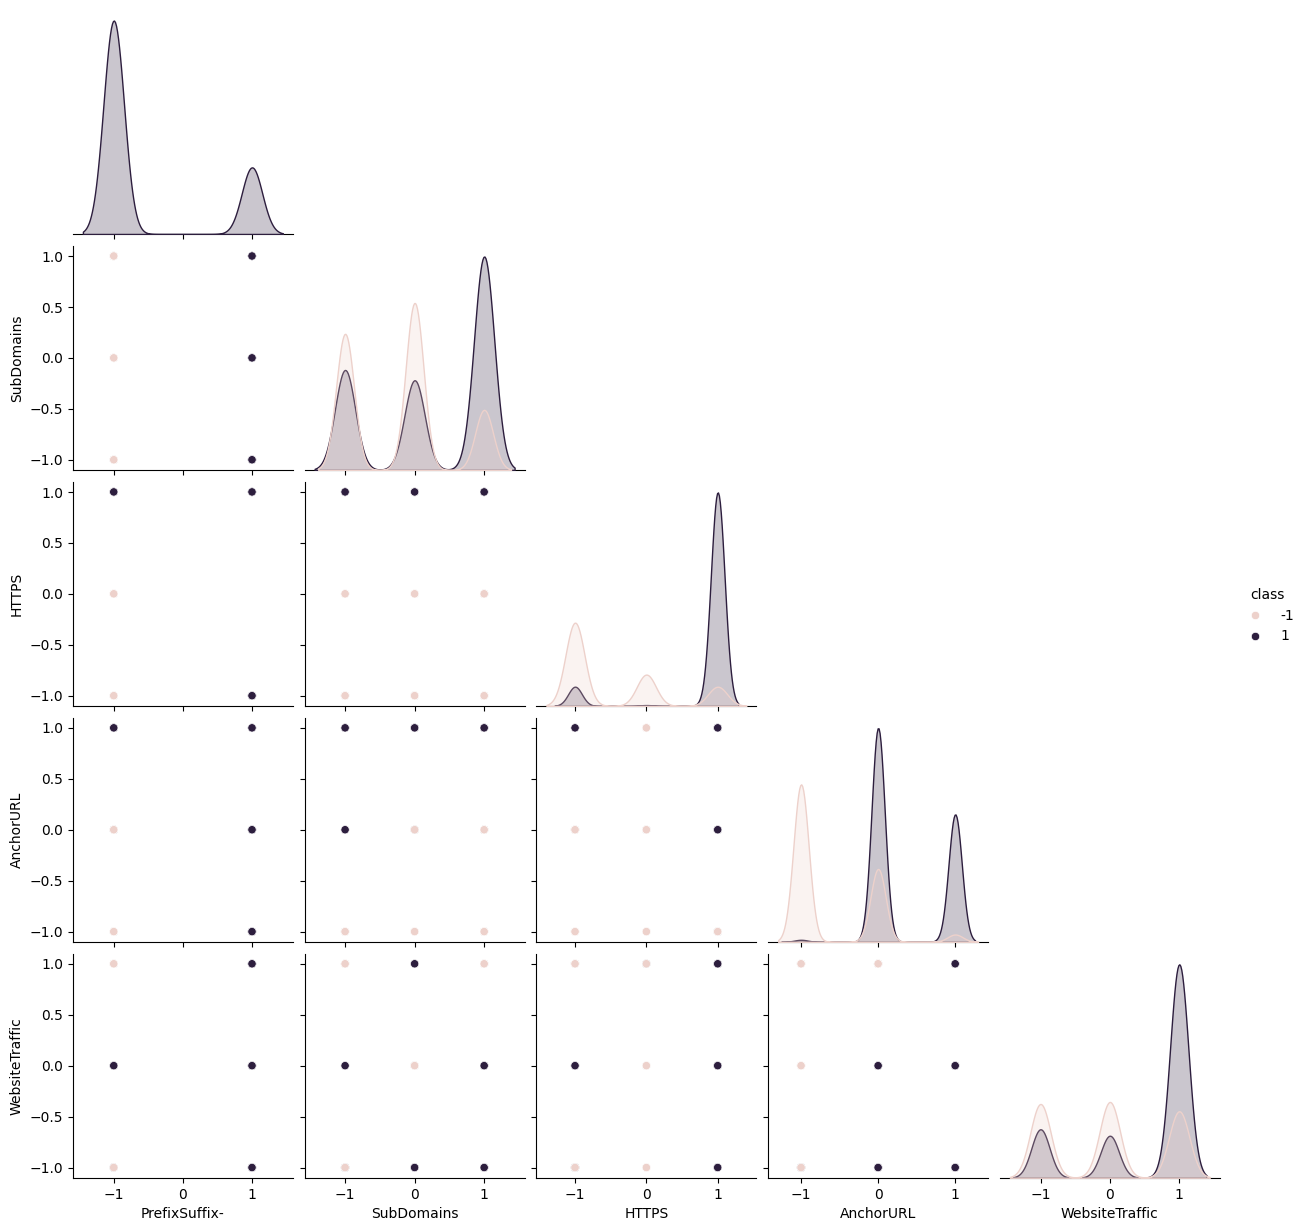

In [11]:
# What is a pairplot?
df = data[['PrefixSuffix-', 'SubDomains', 'HTTPS', 'AnchorURL', 'WebsiteTraffic', 'class']]
sns.pairplot(data=df, hue='class', corner=True)

Text(0.5, 1.0, 'Phishing Count')

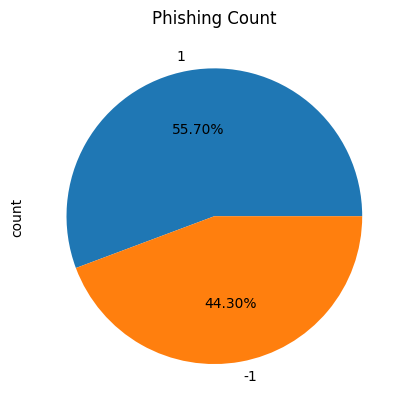

In [12]:
data['class'].value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.title('Phishing Count')

## 3. Train Test Split

In [13]:
x = data.drop(['class'], axis=1)
y = data['class']

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

x_train: (8843, 30)
y_train: (8843,)
x_test: (2211, 30)
y_test: (2211,)


## 4. Model Building and Training

In [15]:
def accuracy_metrics(model, y_train, y_test, y_train_model, y_test_model):
    acc_train = metrics.accuracy_score(y_train, y_train_model)
    acc_test = metrics.accuracy_score(y_test, y_test_model)
    
    f1_train = metrics.f1_score(y_train, y_train_model)
    f1_test = metrics.f1_score(y_test, y_test_model)
    
    recall_train = metrics.recall_score(y_train, y_train_model)
    recall_test = metrics.recall_score(y_test, y_test_model)
    
    precision_train = metrics.precision_score(y_train, y_train_model)
    precision_test = metrics.precision_score(y_test, y_test_model)

    model_stats = {
        'Model': model,
        'Accuracy_train': acc_train,
        'Accuracy_test': acc_test,
        'F1_train': f1_train,
        'F1_test': f1_test,
        'Recall_train': recall_train,
        'Recall_test': recall_test,
        'Precision_train': precision_train,
        'Precision_test': precision_test,
    }
    [print(f'{k}: {v}') for k,v in model_stats.items()]
    return model_stats

### 4.1 Logistic Regression

In [16]:
LogReg = LogisticRegression() # Instantiate the model
LogReg.fit(x_train, y_train)

LogisticRegression()

In [17]:
y_train_log = LogReg.predict(x_train)
y_test_log = LogReg.predict(x_test)

In [18]:
log_reg_stats = accuracy_metrics('Logistic Regression', y_train, y_test, y_train_log, y_test_log)

Model: Logistic Regression
Accuracy_train: 0.9269478683704625
Accuracy_test: 0.9335142469470827
F1_train: 0.9349577124446234
F1_test: 0.9412235105957617
Recall_train: 0.9433157253149126
Recall_test: 0.9530364372469635
Precision_train: 0.9267465069860279
Precision_test: 0.9296998420221169
